In this notebook I trained models only on binary data(without puzzles descriptions).

## Naive Bayes

In [1]:
import pandas as pd

df = pd.read_csv('../data/data.csv')

has_columns = [col for col in df.columns if col.startswith('has')]

X = df[has_columns]
y = df['target']

y = y.replace({
    1: 1,  # Easy
    2: 1,  # Easy
    3: 2,  # Medium
    4: 3,  # Hard
    5: 3   # Hard
})

In [2]:
X.head()

,has_araf,has_arrows_(variante),has_xv_(variante),has_kompass,has_fibonacci_(thema),has_alles_oder_nichts,has_hamle,has_compass_(variante),has_icebarn,has_windoku_(variante),...,has_xy-differences_(variante),has_arukone,has_norinori,has_magisches_labyrinth,has_springerzug_(thema),has_palindrome_(variante),has_produkte,has_maximum_(variante),has_shakashaka,has_difference_(variante)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y.head()

0    2
1    3
2    1
3    2
4    2
Name: target, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 170), (2000, 170), (8000,), (2000,))

In [5]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

MultinomialNB()

              precision    recall  f1-score   support

           1       0.48      0.41      0.44       696
           2       0.39      0.62      0.48       691
           3       0.53      0.25      0.34       613

    accuracy                           0.43      2000
   macro avg       0.46      0.43      0.42      2000
weighted avg       0.46      0.43      0.42      2000



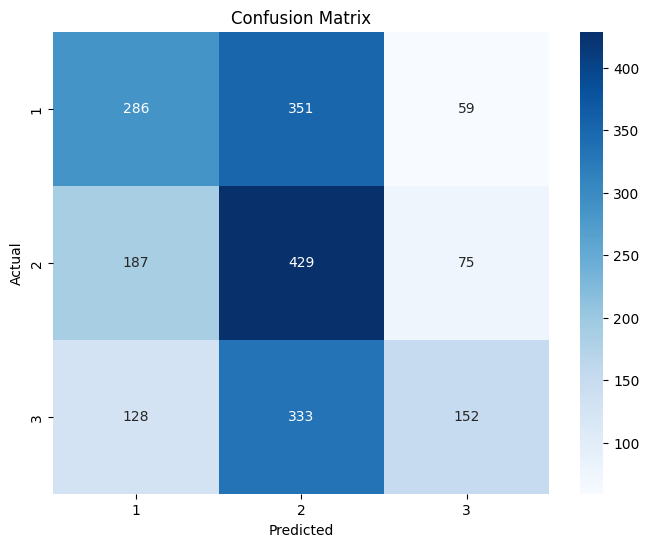

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

y_pred = nb_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## SVM

In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

print(f"Class Weights: {class_weights_dict}")


Class Weights: {np.int64(1): np.float64(0.9789525208027411), np.int64(2): np.float64(0.9602688752850799), np.int64(3): np.float64(1.067093504068294)}


In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel='rbf', class_weight=class_weights_dict, C=1.0, random_state=42)

svm_classifier.fit(X_train_scaled, y_train)

SVC(class_weight={np.int64(1): np.float64(0.9789525208027411),
                  np.int64(2): np.float64(0.9602688752850799),
                  np.int64(3): np.float64(1.067093504068294)},
    random_state=42)

              precision    recall  f1-score   support

           1       0.49      0.42      0.45       696
           2       0.38      0.58      0.46       691
           3       0.46      0.26      0.34       613

    accuracy                           0.43      2000
   macro avg       0.44      0.42      0.42      2000
weighted avg       0.44      0.43      0.42      2000



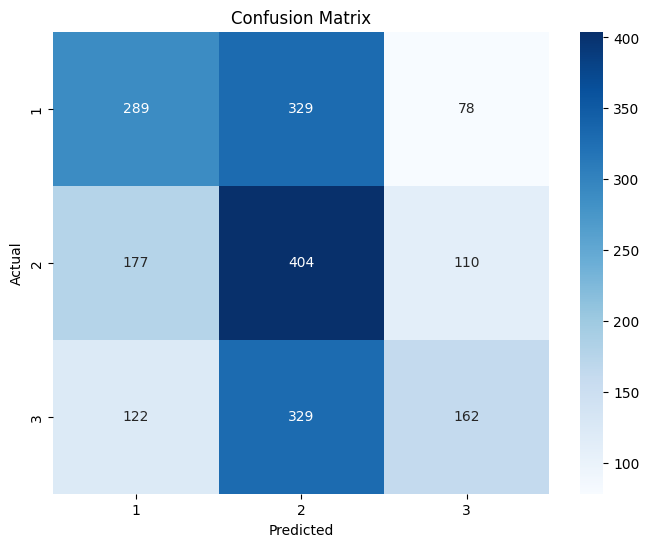

In [11]:
y_pred = svm_classifier.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Ensemble model

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
class_weights_dict = {
    0: 1.0,  # Easy
    1: 1.0,  # Medium (higher weight)
    2: 1.1   # Hard
}

svm_classifier = SVC(kernel='rbf', class_weight=class_weights_dict, C=1.0, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)
nb_classifier = MultinomialNB()

In [34]:
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_classifier), 
    ('naive_bayes', nb_classifier), 
    ('random_forest', rf_classifier)
], voting='hard')

ensemble_model.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(class_weight={0: 1.0, 1: 1.0, 2: 1.1},
                                  random_state=42)),
                             ('naive_bayes', MultinomialNB()),
                             ('random_forest',
                              RandomForestClassifier(class_weight={0: 1.0,
                                                                   1: 1.0,
                                                                   2: 1.1},
                                                     random_state=42))])

Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           1       0.48      0.45      0.47       696
           2       0.39      0.50      0.44       691
           3       0.45      0.33      0.38       613

    accuracy                           0.43      2000
   macro avg       0.44      0.43      0.43      2000
weighted avg       0.44      0.43      0.43      2000



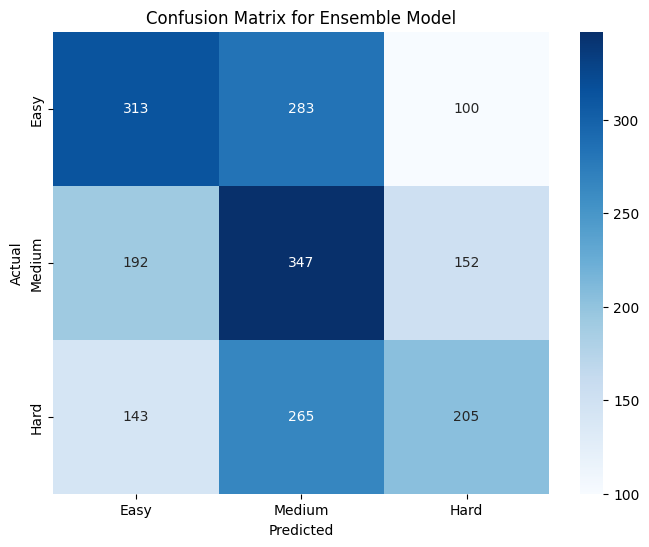

In [35]:
y_pred = ensemble_model.predict(X_test_scaled)

print("Classification Report for Ensemble Model:")
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
plt.title("Confusion Matrix for Ensemble Model")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Oridinal Neural Network

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

In [71]:
df = pd.read_csv('../data/data.csv')

# Filter columns that start with 'has'
X = df.filter(like='has').values
y = df['target']  # Assuming the target column is already mapped to 1, 2, 3

y = y.replace({
    1: 1,  # Easy
    2: 1,  # Easy
    3: 2,  # Medium
    4: 3,  # Hard
    5: 3   # Hard
})

# Convert the data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
# Convert the data to PyTorch tensors and adjust the labels
y = torch.tensor(y - 1, dtype=torch.long)  # Subtract 1 to make labels 0, 1, and 2
  # CrossEntropyLoss expects class indices as long

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OrdinalNeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super(OrdinalNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128,64)
        self.output_layer = nn.Linear(64, num_classes - 1)  # For ordinal classification, we have num_classes - 1 thresholds

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        logits = self.output_layer(x)  # Logits for the thresholds
        return logits


In [85]:
class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, logits, target):
        # Create ordinal target one-vs-all encoding
        target_one_vs_all = torch.zeros(logits.size(), device=logits.device)
        for i in range(1, self.num_classes):
            target_one_vs_all[:, i - 1] = (target >= i).float()

        # Apply sigmoid to logits and compute BCE loss
        logits = torch.sigmoid(logits)
        loss = F.binary_cross_entropy(logits, target_one_vs_all)

        return loss


In [86]:
input_size = X_train.shape[1]  # Number of binary features
num_classes = 3  # Since we have 3 target classes

# Initialize the model, loss function, and optimizer
model = BinaryNN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [87]:
def train(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            logits = model(inputs)
            loss = criterion(logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")


def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            logits = model(inputs)

            # Convert logits to ordinal class prediction
            predictions = (logits > 0.5).sum(dim=1).cpu()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.numpy())

    return y_true, y_pred


In [89]:
# Define the input dimension and hyperparameters
input_dim = X_train.shape[1]
hidden_units = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 20

device = 'cpu'

# Initialize the model, criterion, and optimizer
model = OrdinalNeuralNetwork(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = OrdinalCrossEntropyLoss(num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# Evaluate the model
y_true, y_pred = evaluate(model, test_loader)


Epoch 1/20, Loss: 0.6276286625862122
Epoch 2/20, Loss: 0.5958403875827789
Epoch 3/20, Loss: 0.587185308098793
Epoch 4/20, Loss: 0.5789217908382416
Epoch 5/20, Loss: 0.572665190577507
Epoch 6/20, Loss: 0.5662208865880967
Epoch 7/20, Loss: 0.5588773877620697
Epoch 8/20, Loss: 0.5523911303281784
Epoch 9/20, Loss: 0.5466680055856705
Epoch 10/20, Loss: 0.5411972962617874
Epoch 11/20, Loss: 0.5347885571718216
Epoch 12/20, Loss: 0.5293513798713684
Epoch 13/20, Loss: 0.5241156606674194
Epoch 14/20, Loss: 0.5195489642620087
Epoch 15/20, Loss: 0.5138488166332245
Epoch 16/20, Loss: 0.5089906868934632
Epoch 17/20, Loss: 0.5059121376276017
Epoch 18/20, Loss: 0.5007428777217865
Epoch 19/20, Loss: 0.49789063024520874
Epoch 20/20, Loss: 0.49281974995136263


Classification Report:
              precision    recall  f1-score   support

        Easy       0.50      0.40      0.44       696
      Medium       0.38      0.70      0.49       691
        Hard       0.55      0.16      0.24       613

    accuracy                           0.43      2000
   macro avg       0.48      0.42      0.39      2000
weighted avg       0.47      0.43      0.40      2000



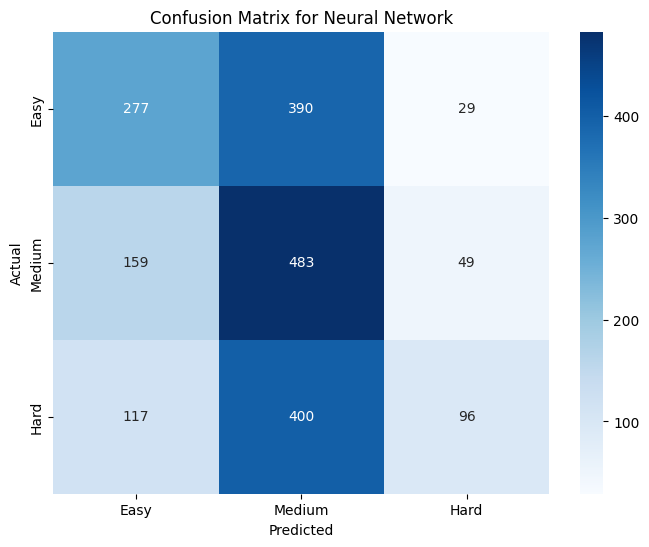

In [90]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Easy', 'Medium', 'Hard']))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
plt.title("Confusion Matrix for Neural Network")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## complete features classifier

## Naive Bayes

In [51]:
df = pd.read_csv('../data/data.csv')

has_columns = [col for col in df.columns if col.startswith('has')]

X = df[has_columns]
y = df['target']

y = y.replace({
    1: 1,  # Easy
    2: 1,  # Easy
    3: 2,  # Medium
    4: 3,  # Hard
    5: 3   # Hard
})

In [56]:
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_features = vectorizer.fit_transform(df['features'])

binary_columns = df.filter(like='has')

In [57]:
import numpy as np
from scipy.sparse import hstack

binary_features = binary_columns.values
final_features = hstack([tfidf_features, binary_features])

X = final_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.56      0.55       696
           2       0.42      0.53      0.47       691
           3       0.59      0.40      0.48       613

    accuracy                           0.50      2000
   macro avg       0.52      0.50      0.50      2000
weighted avg       0.52      0.50      0.50      2000



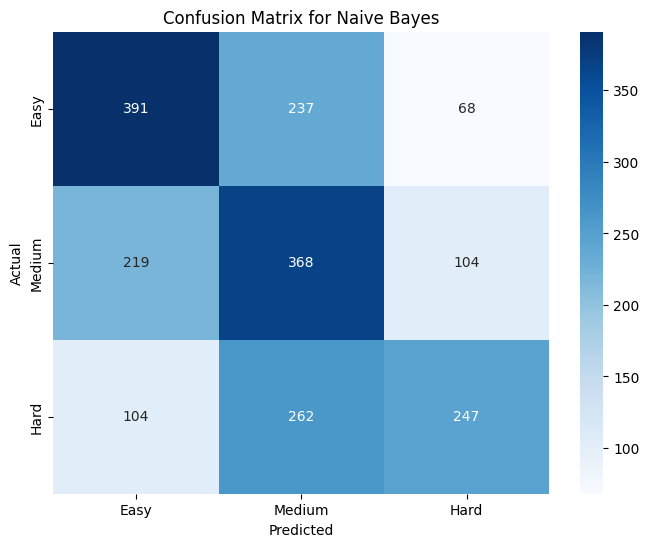

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
plt.title("Confusion Matrix for Naive Bayes")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## SVM

In [60]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

print(f"Class Weights: {class_weights_dict}")


Class Weights: {np.int64(1): np.float64(0.9789525208027411), np.int64(2): np.float64(0.9602688752850799), np.int64(3): np.float64(1.067093504068294)}


In [61]:
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel='rbf', class_weight=class_weights_dict, C=1.0, random_state=42)

svm_classifier.fit(X_train_scaled, y_train)

SVC(class_weight={np.int64(1): np.float64(0.9789525208027411),
                  np.int64(2): np.float64(0.9602688752850799),
                  np.int64(3): np.float64(1.067093504068294)},
    random_state=42)

              precision    recall  f1-score   support

           1       0.61      0.51      0.56       696
           2       0.43      0.47      0.45       691
           3       0.50      0.54      0.52       613

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.51      2000
weighted avg       0.52      0.51      0.51      2000



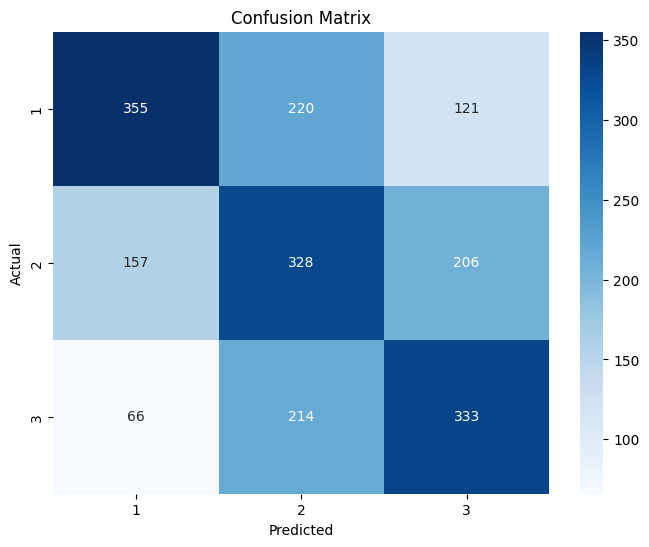

In [62]:
y_pred = svm_classifier.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Training on comments

              precision    recall  f1-score   support

           1       0.47      0.03      0.06       696
           2       0.35      0.94      0.51       691
           3       0.49      0.07      0.12       613

    accuracy                           0.36      2000
   macro avg       0.44      0.35      0.23      2000
weighted avg       0.43      0.36      0.23      2000



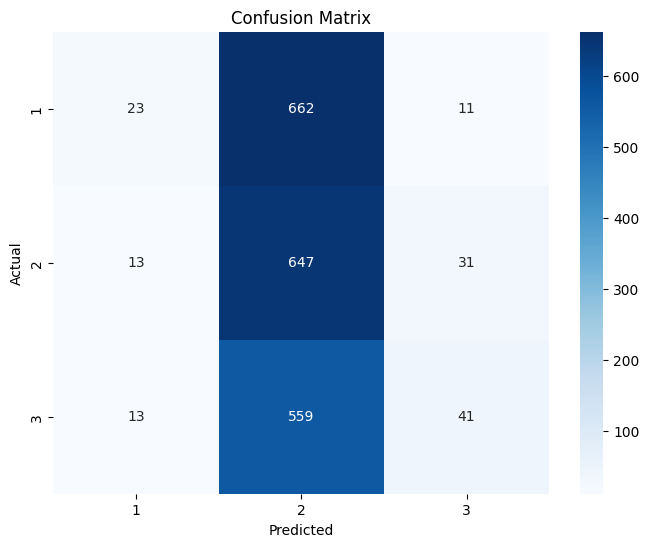

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('../data/data.csv')

# Feature engineering: Create 'has_easy' and 'has_hard' columns
df['has_easy'] = df['comments'].fillna('').str.contains('easy', case=False).astype(int)
df['has_hard'] = df['comments'].fillna('').str.contains('hard', case=False).astype(int)

# Remap the target column from 1-5 to 1-3
df['target'] = df['target'].replace({
    1: 1, 2: 1, 3: 2, 4: 3, 5: 3
})

# Select only 'has_easy' and 'has_hard' columns as features
X = df[['has_easy', 'has_hard']]

# Define the target column
y = df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()